# Installs

In [1]:
!pip install 'monai[einops]' --no-index --find-links=../input/hubmap-library-download/

Looking in links: ../input/hubmap-library-download/
Processing /kaggle/input/hubmap-library-download/monai-0.9.0-202206131636-py3-none-any.whl
Processing /kaggle/input/hubmap-library-download/einops-0.4.1-py3-none-any.whl


# Imports

In [2]:
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Dict
from typing import Optional
from typing import Tuple

import monai
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import tifffile
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from monai.data import CSVDataset
from monai.data import DataLoader
from monai.data import ImageReader
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_io as tfio
import cv2
from matplotlib.patches import Rectangle

# Paths & Settings

In [3]:
KAGGLE_DIR = Path("/") / "kaggle"

INPUT_DIR = KAGGLE_DIR / "input"
OUTPUT_DIR = KAGGLE_DIR / "working"


COMPETITION_DATA_DIR = INPUT_DIR / "hubmap-organ-segmentation"

TRAIN_PREPARED_CSV_PATH = "train_prepared.csv"
VAL_PRED_PREPARED_CSV_PATH = "val_pred_prepared.csv"
TEST_PREPARED_CSV_PATH = "test_prepared.csv"

N_SPLITS = 4
RANDOM_SEED = 2022
SPATIAL_SIZE = 768
VAL_FOLD = 0
NUM_WORKERS = 2
BATCH_SIZE = 4
MODEL = "unet"
LOSS = "dice"
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.0
FAST_DEV_RUN = False
GPUS = 1
MAX_EPOCHS = 90
PRECISION = 16
DEBUG = False
BACKBONE = 'efficientnet-b5'

DEVICE = "cuda"
THRESHOLD = 0.5

def rgb2hex(rgb_tuple):
    r,g,b = rgb_tuple
    def clamp(x): 
        return max(0, min(x, 255))
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))

ORGANS = ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']
_COLOURS = [(230, 0, 73), (11, 180, 255), (80, 233, 145), (230, 216, 0), (155, 25, 245)]
O2C_MAP = {_o:_c for _o,_c in zip(ORGANS, _COLOURS)}
O2C_HEX_MAP = {_o:rgb2hex(_c) for _o,_c in O2C_MAP.items()}

# Prepare DataFrames (Add paths and create folds)

In [4]:
def add_path_to_df(df: pd.DataFrame, data_dir: Path, type_: str, stage: str) -> pd.DataFrame:
    ending = ".tiff" if type_ == "image" else ".npy"
    
    dir_ = str(data_dir / f"{stage}_{type_}s") if type_ == "image" else f"{stage}_{type_}s"
    df[type_] = dir_ + "/" + df["id"].astype(str) + ending
    return df


def add_paths_to_df(df: pd.DataFrame, data_dir: Path, stage: str) -> pd.DataFrame:
    df = add_path_to_df(df, data_dir, "image", stage)
    df = add_path_to_df(df, data_dir, "mask", stage)
    return df


def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = fold

    return df


def prepare_data(data_dir: Path, stage: str, n_splits: int, random_seed: int) -> None:
    df = pd.read_csv(data_dir / f"{stage}.csv")
    df = add_paths_to_df(df, data_dir, stage)

    if stage == "train":
        df = create_folds(df, n_splits, random_seed)

    filename = f"{stage}_prepared.csv"
    df.to_csv(filename, index=False)


    return df

In [5]:
train_df = prepare_data(COMPETITION_DATA_DIR, "train", N_SPLITS, RANDOM_SEED)
test_df = prepare_data(COMPETITION_DATA_DIR, "test", N_SPLITS, RANDOM_SEED)

In [6]:
test_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,image,mask
0,10078,spleen,Hubmap,2023,2023,0.4945,4,/kaggle/input/hubmap-organ-segmentation/test_i...,test_masks/10078.npy


# Save Train Masks as NumPy Arrays

In [7]:
def rle2mask(mask_rle: str, shape: Tuple[int, int]) -> np.ndarray:
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def save_array(file_path: str, array: np.ndarray) -> None:
    file_path = Path(file_path)
    file_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(file_path, array)


def save_masks(df: pd.DataFrame) -> None:
    for row in tqdm(df.itertuples(), total=len(df)):
        mask = rle2mask(row.rle, shape=(row.img_width, row.img_height))
        save_array(row.mask, mask)

In [8]:
save_masks(train_df)

  0%|          | 0/351 [00:00<?, ?it/s]

# Lightning DataModule

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

class TIFFImageReader(ImageReader):
    def read(self, data: str) -> np.ndarray:
        image = tifffile.imread(data)
        image = rgb2gray(image)
        return image

    def get_data(self, img: np.ndarray) -> Tuple[np.ndarray, Dict[str, Any]]:
        return img, {"spatial_shape": np.asarray(img.shape), "original_channel_dim": -1}

    def verify_suffix(self, filename: str) -> bool:
        return ".tiff" in filename

In [10]:
class LitDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_csv_path: str,
        test_csv_path: str,
        spatial_size: int,
        val_fold: int,
        batch_size: int,
        num_workers: int,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.train_df = pd.read_csv(train_csv_path)
        self.test_df = pd.read_csv(test_csv_path)

        self.train_transform, self.val_transform, self.test_transform = self._init_transforms()
        
    def _init_transforms(self) -> Tuple[Callable, Callable, Callable]:
        spatial_size = (self.hparams.spatial_size, self.hparams.spatial_size)
        train_transform = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"], reader=TIFFImageReader),
                monai.transforms.AddChanneld(keys=["image"]),
                monai.transforms.ScaleIntensityd(keys=["image"]),
                monai.transforms.LoadImaged(keys=["mask"]),
                monai.transforms.AddChanneld(keys=["mask"]),
                monai.transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
                monai.transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
                monai.transforms.RandRotate90d(keys=["image", "mask"], prob=0.75, spatial_axes=(0, 1)),
                monai.transforms.OneOf(
                    [
                        #monai.transforms.RandGaussianNoised(keys=["image"], prob=1.0, std=0.1),
                        monai.transforms.RandAdjustContrastd(keys=["image"], prob=1.0, gamma=(0.5, 4.5)),
                        monai.transforms.RandShiftIntensityd(keys=["image"], prob=1.0, offsets=(0.1, 0.2)),
                        monai.transforms.RandHistogramShiftd(keys=["image"], prob=1.0),
                    ]
                ),
                monai.transforms.OneOf(
                    [
                        monai.transforms.RandGridDistortiond(keys=["image", "mask"], prob=0.5, distort_limit=0.2),
                        #monai.transforms.RandZoomd(keys=["image", "mask"], prob=0.5, spatial_size=spatial_size,  mode="nearest"),

                    ]
                ),
                monai.transforms.Resized(keys=["image", "mask"], spatial_size=spatial_size, mode="nearest"),
                monai.transforms.ToTensord(keys=["image", "mask"]),
            ]
        )

        val_transform = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"], reader=TIFFImageReader),
                monai.transforms.AddChanneld(keys=["image"]),
                monai.transforms.ScaleIntensityd(keys=["image"]),
                monai.transforms.LoadImaged(keys=["mask"]),
                monai.transforms.AddChanneld(keys=["mask"]),
                #monai.transforms.RandZoomd(keys=["image", "mask"], prob=0.5, spatial_size=spatial_size,  mode="nearest"),
                monai.transforms.Resized(keys=["image", "mask"], spatial_size=spatial_size, mode="nearest"),
                monai.transforms.ToTensord(keys=["image", "mask"]),
            ]
        )

        test_transform = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"], reader=TIFFImageReader),
                monai.transforms.AddChanneld(keys=["image"]),
                monai.transforms.ScaleIntensityd(keys=["image"]),
                monai.transforms.Resized(keys=["image"], spatial_size=spatial_size, mode="nearest"),
                monai.transforms.ToTensord(keys=["image"]),
            ]
        )

        return train_transform, val_transform, test_transform

    def setup(self, stage: str = None):
        if stage == "fit" or stage is None:
            train_df = self.train_df[self.train_df.fold != self.hparams.val_fold].reset_index(drop=True)
            val_df = self.train_df[self.train_df.fold == self.hparams.val_fold].reset_index(drop=True)

            self.train_dataset = self._dataset(train_df, transform=self.train_transform)
            self.val_dataset = self._dataset(val_df, transform=self.val_transform)

        if stage == "test" or stage is None:
            self.test_dataset = self._dataset(self.test_df, transform=self.test_transform)

    def _dataset(self, df: pd.DataFrame, transform: Callable) -> CSVDataset:
        return CSVDataset(src=df, transform=transform)

    def train_dataloader(self) -> DataLoader:
        return self._dataloader(self.train_dataset, train=True)

    def val_dataloader(self) -> DataLoader:
        return self._dataloader(self.val_dataset)

    def test_dataloader(self) -> DataLoader:
        return self._dataloader(self.test_dataset)

    def _dataloader(self, dataset: CSVDataset, train: bool = False) -> DataLoader:
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
        )

## Setup DataModule

In [11]:
nrows = 1

data_module = LitDataModule(
    train_csv_path=TRAIN_PREPARED_CSV_PATH,
    test_csv_path=TEST_PREPARED_CSV_PATH,
    spatial_size=SPATIAL_SIZE,
    val_fold=VAL_FOLD,
    batch_size=nrows ** 2,
    num_workers=NUM_WORKERS,
)
data_module.setup()

# Lightning Module

In [12]:
from typing import List, Optional, Sequence, Tuple, Union

from monai.networks.blocks import UpSample
from monai.networks.layers.factories import Conv
from monai.networks.layers.utils import get_act_layer
from monai.networks.nets import EfficientNetBNFeatures
from monai.networks.nets.basic_unet import UpCat
from monai.utils import InterpolateMode

__all__ = ["FlexibleUNet"]

encoder_feature_channel = {
    "efficientnet-b0": (16, 24, 40, 112, 320),
    "efficientnet-b1": (16, 24, 40, 112, 320),
    "efficientnet-b2": (16, 24, 48, 120, 352),
    "efficientnet-b3": (24, 32, 48, 136, 384),
    "efficientnet-b4": (24, 32, 56, 160, 448),
    "efficientnet-b5": (24, 40, 64, 176, 512),
    "efficientnet-b6": (32, 40, 72, 200, 576),
    "efficientnet-b7": (32, 48, 80, 224, 640),
    "efficientnet-b8": (32, 56, 88, 248, 704),
    "efficientnet-l2": (72, 104, 176, 480, 1376),
}

def _get_encoder_channels_by_backbone(backbone: str, in_channels: int = 3) -> tuple:
    """
    Get the encoder output channels by given backbone name.

    Args:
        backbone: name of backbone to generate features, can be from [efficientnet-b0, ..., efficientnet-b7].
        in_channels: channel of input tensor, default to 3.

    Returns:
        A tuple of output feature map channels' length .
    """
    encoder_channel_tuple = encoder_feature_channel[backbone]
    encoder_channel_list = [in_channels] + list(encoder_channel_tuple)
    encoder_channel = tuple(encoder_channel_list)
    return encoder_channel


class UNetDecoder(nn.Module):
    """
    UNet Decoder.
    This class refers to `segmentation_models.pytorch
    <https://github.com/qubvel/segmentation_models.pytorch>`_.

    Args:
        spatial_dims: number of spatial dimensions.
        encoder_channels: number of output channels for all feature maps in encoder.
            `len(encoder_channels)` should be no less than 2.
        decoder_channels: number of output channels for all feature maps in decoder.
            `len(decoder_channels)` should equal to `len(encoder_channels) - 1`.
        act: activation type and arguments.
        norm: feature normalization type and arguments.
        dropout: dropout ratio.
        bias: whether to have a bias term in convolution blocks in this decoder.
        upsample: upsampling mode, available options are
            ``"deconv"``, ``"pixelshuffle"``, ``"nontrainable"``.
        pre_conv: a conv block applied before upsampling.
            Only used in the "nontrainable" or "pixelshuffle" mode.
        interp_mode: {``"nearest"``, ``"linear"``, ``"bilinear"``, ``"bicubic"``, ``"trilinear"``}
            Only used in the "nontrainable" mode.
        align_corners: set the align_corners parameter for upsample. Defaults to True.
            Only used in the "nontrainable" mode.
        is_pad: whether to pad upsampling features to fit the encoder spatial dims.

    """

    def __init__(
        self,
        spatial_dims: int,
        encoder_channels: Sequence[int],
        decoder_channels: Sequence[int],
        act: Union[str, tuple],
        norm: Union[str, tuple],
        dropout: Union[float, tuple],
        bias: bool,
        upsample: str,
        pre_conv: Optional[str],
        interp_mode: str,
        align_corners: Optional[bool],

    ):

        super().__init__()
        if len(encoder_channels) < 2:
            raise ValueError("the length of `encoder_channels` should be no less than 2.")
        if len(decoder_channels) != len(encoder_channels) - 1:
            raise ValueError("`len(decoder_channels)` should equal to `len(encoder_channels) - 1`.")

        in_channels = [encoder_channels[-1]] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:-1][::-1]) + [0]
        halves = [True] * (len(skip_channels) - 1)
        halves.append(False)
        blocks = []
        for in_chn, skip_chn, out_chn, halve in zip(in_channels, skip_channels, decoder_channels, halves):
            blocks.append(
                UpCat(
                    spatial_dims=spatial_dims,
                    in_chns=in_chn,
                    cat_chns=skip_chn,
                    out_chns=out_chn,
                    act=act,
                    norm=norm,
                    dropout=dropout,
                    bias=bias,
                    upsample=upsample,
                    pre_conv=pre_conv,
                    interp_mode=interp_mode,
                    align_corners=align_corners,
                    halves=halve,
                )
            )
        self.blocks = nn.ModuleList(blocks)

    def forward(self, features: List[torch.Tensor], skip_connect: int = 4):
        skips = features[:-1][::-1]
        features = features[1:][::-1]

        x = features[0]
        for i, block in enumerate(self.blocks):
            if i < skip_connect:
                skip = skips[i]
            else:
                skip = None
            x = block(x, skip)

        return x


class SegmentationHead(nn.Sequential):
    """
    Segmentation head.
    This class refers to `segmentation_models.pytorch
    <https://github.com/qubvel/segmentation_models.pytorch>`_.

    Args:
        spatial_dims: number of spatial dimensions.
        in_channels: number of input channels for the block.
        out_channels: number of output channels for the block.
        kernel_size: kernel size for the conv layer.
        act: activation type and arguments.
        scale_factor: multiplier for spatial size. Has to match input size if it is a tuple.

    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        act: Optional[Union[Tuple, str]] = None,
        scale_factor: float = 1.0,
    ):

        conv_layer = Conv[Conv.CONV, spatial_dims](
            in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size // 2
        )
        up_layer: nn.Module = nn.Identity()
        if scale_factor > 1.0:
            up_layer = UpSample(
                spatial_dims=spatial_dims,
                scale_factor=scale_factor,
                mode="nontrainable",
                pre_conv=None,
                interp_mode=InterpolateMode.LINEAR,
            )
        if act is not None:
            act_layer = get_act_layer(act)
        else:
            act_layer = nn.Identity()
        super().__init__(conv_layer, up_layer, act_layer)


class FlexibleUNet(nn.Module):
    """
    A flexible implementation of UNet-like encoder-decoder architecture.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        backbone: str,
        pretrained: bool = False,
        decoder_channels: Tuple = (256, 128, 64, 32, 16),
        spatial_dims: int = 2,
        norm: Union[str, tuple] = ("batch", {"eps": 1e-3, "momentum": 0.1}),
        act: Union[str, tuple] = ("relu", {"inplace": True}),
        dropout: Union[float, tuple] = 0.0,
        decoder_bias: bool = False,
        upsample: str = "nontrainable",
        interp_mode: str = "nearest",
        is_pad: bool = True,
    ) -> None:
        """
        A flexible implement of UNet, in which the backbone/encoder can be replaced with
        any efficient network. Currently the input must have a 2 or 3 spatial dimension
        and the spatial size of each dimension must be a multiple of 32 if is pad parameter
        is False

        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            backbone: name of backbones to initialize, only support efficientnet right now,
                can be from [efficientnet-b0,..., efficientnet-b8, efficientnet-l2].
            pretrained: whether to initialize pretrained ImageNet weights, only available
                for spatial_dims=2 and batch norm is used, default to False.
            decoder_channels: number of output channels for all feature maps in decoder.
                `len(decoder_channels)` should equal to `len(encoder_channels) - 1`,default
                to (256, 128, 64, 32, 16).
            spatial_dims: number of spatial dimensions, default to 2.
            norm: normalization type and arguments, default to ("batch", {"eps": 1e-3,
                "momentum": 0.1}).
            act: activation type and arguments, default to ("relu", {"inplace": True}).
            dropout: dropout ratio, default to 0.0.
            decoder_bias: whether to have a bias term in decoder's convolution blocks.
            upsample: upsampling mode, available options are``"deconv"``, ``"pixelshuffle"``,
                ``"nontrainable"``.
            interp_mode: {``"nearest"``, ``"linear"``, ``"bilinear"``, ``"bicubic"``, ``"trilinear"``}
                Only used in the "nontrainable" mode.
            is_pad: whether to pad upsampling features to fit features from encoder. Default to True.
                If this parameter is set to "True", the spatial dim of network input can be arbitary
                size, which is not supported by TensorRT. Otherwise, it must be a multiple of 32.
        """
        super().__init__()

        if backbone not in encoder_feature_channel:
            raise ValueError(f"invalid model_name {backbone} found, must be one of {encoder_feature_channel.keys()}.")

        if spatial_dims not in (2, 3):
            raise ValueError("spatial_dims can only be 2 or 3.")

        adv_prop = "ap" in backbone

        self.backbone = backbone
        self.spatial_dims = spatial_dims
        model_name = backbone
        encoder_channels = _get_encoder_channels_by_backbone(backbone, in_channels)
        self.encoder = EfficientNetBNFeatures(
            model_name=model_name,
            pretrained=pretrained,
            in_channels=in_channels,
            spatial_dims=spatial_dims,
            norm=norm,
            adv_prop=adv_prop,
        )
        self.decoder = UNetDecoder(
            spatial_dims=spatial_dims,
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            act=act,
            norm=norm,
            dropout=dropout,
            bias=decoder_bias,
            upsample=upsample,
            interp_mode=interp_mode,
            pre_conv=None,
            align_corners=None,
        )
        self.segmentation_head = SegmentationHead(
            spatial_dims=spatial_dims,
            in_channels=decoder_channels[-1],
            out_channels=out_channels,
            kernel_size=3,
            act=None,
        )


    def forward(self, inputs: torch.Tensor):
        """
        Do a typical encoder-decoder-header inference.

        Args:
            inputs: input should have spatially N dimensions ``(Batch, in_channels, dim_0[, dim_1, ..., dim_N])``,
                N is defined by `dimensions`.

        Returns:
            A torch Tensor of "raw" predictions in shape ``(Batch, out_channels, dim_0[, dim_1, ..., dim_N])``.

        """
        x = inputs
        enc_out = self.encoder(x)
        decoder_out = self.decoder(enc_out)
        x_seg = self.segmentation_head(decoder_out)

        return x_seg

In [13]:
class LitModule(pl.LightningModule):
    def __init__(
        self,
        model: str,
        loss: str,
        spatial_size: int,
        learning_rate: float,
        weight_decay: float,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.model = self._init_model()

        self.loss_fn = self._init_loss_fn()

        # TODO: add metric

    def _init_model(self) -> nn.Module:
        spatial_size = (self.hparams.spatial_size, self.hparams.spatial_size)
        
        if self.hparams.model == "unet":
            return FlexibleUNet(
                in_channels=1,
                out_channels=1,
                backbone = BACKBONE,
                pretrained=False
            )
        elif self.hparams.model == "attention_unet":
            return monai.networks.nets.AttentionUnet(
                spatial_dims=2,
                in_channels=3,
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
            )
        elif self.hparams.model == "unetr":
            return monai.networks.nets.UNETR(
                in_channels=3,
                img_size=spatial_size,
                out_channels=1,
                spatial_dims=2,
            )
        elif self.hparams.model == "swin_unetr":
            return monai.networks.nets.SwinUNETR(
                img_size=spatial_size,
                in_channels=3,
                out_channels=1,
                spatial_dims=2,
            )

    def _init_loss_fn(self):
        if self.hparams.loss == "dice":
            return monai.losses.DiceLoss(sigmoid=True)
        elif self.hparams.loss == "bce":
            return nn.BCEWithLogitsLoss()

    def configure_optimizers(self):
        # TODO: try other optimizers and schedulers
        return torch.optim.Adam(
            params=self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        return self.model(images)

    def training_step(self, batch: Dict, batch_idx: int) -> torch.Tensor:
        images, masks = batch["image"], batch["mask"]
        outputs = self(images)

        loss = self.loss_fn(outputs, masks)

        self.log("train_loss", loss, batch_size=images.shape[0])

        return loss

    def validation_step(self, batch: Dict, batch_idx: int) -> None:
        images, masks = batch["image"], batch["mask"]
        outputs = self(images)

        loss = self.loss_fn(outputs, masks)

        self.log("val_loss", loss, prog_bar=True, batch_size=images.shape[0])

    @classmethod
    def load_eval_checkpoint(cls, checkpoint_path: str, device: str) -> nn.Module:
        module = cls.load_from_checkpoint(checkpoint_path=checkpoint_path).to(device)
        module.eval()

        return module

# Infer

In [14]:
def mask2rle(img):
    '''
    Efficient implementation of mask2rle, from @paulorzp
    --
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    Source: https://www.kaggle.com/xhlulu/efficient-mask2rle
    '''
    pixels = img.T.flatten()
    pixels = np.pad(pixels, ((1, 1), ))
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


@torch.no_grad()
def create_pred_df(module, dataloader, threshold):
    ids = []
    rles = []
    for batch in tqdm(dataloader):
        id_ = batch["id"].numpy()[0]
        height = batch["img_height"].numpy()[0]
        width = batch["img_width"].numpy()[0]
        
        images = batch["image"].to(module.device)
        outputs = module(images)[0]
        
        post_pred_transform = monai.transforms.Compose(
            [
                monai.transforms.Resize(spatial_size=(height, width), mode="nearest"),
                monai.transforms.Activations(sigmoid=True),
                monai.transforms.AsDiscrete(threshold=threshold),
            ]
        )
        
        mask = post_pred_transform(outputs).to(torch.uint8).cpu().detach().numpy()[0]
        
        rle = mask2rle(mask)
        
        ids.append(id_)
        rles.append(rle)
        
    return pd.DataFrame({"id": ids, "rle": rles})


def infer(
    checkpoint_path: str,
    device: str = DEVICE,
    train_csv_path: str = TRAIN_PREPARED_CSV_PATH,
    test_csv_path: str = TEST_PREPARED_CSV_PATH,
    spatial_size: int = SPATIAL_SIZE,
    num_workers: int = NUM_WORKERS,
    threshold: float = THRESHOLD,
):
    module = LitModule.load_eval_checkpoint(checkpoint_path, device)

    data_module = LitDataModule(
        train_csv_path=train_csv_path,
        test_csv_path=test_csv_path,
        spatial_size=spatial_size,
        val_fold=0,
        batch_size=1,
        num_workers=num_workers,
    )
    data_module.setup()
    
    val_dataloader = data_module.val_dataloader()
    test_dataloader = data_module.test_dataloader()
    
    val_pred_df = create_pred_df(module, val_dataloader, threshold)
    test_pred_df = create_pred_df(module, test_dataloader, threshold)
    
    return val_pred_df, test_pred_df

In [15]:
checkpoint_path = list(Path("../input/90-epoch-valid-hubmap-plateau/logs/lightning_logs/version_0/checkpoints/").glob("*.ckpt"))[0]
val_pred_df, test_pred_df = infer(checkpoint_path)

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
test_pred_df.to_csv("submission.csv", index=False)
test_pred_df

,id,rle
0,10078,395977 14 398000 14 400023 14 402031 47 404054...


# Predicted Display

In [17]:
#val_pred_df =  val_pred_df[0:1]
val_original = train_df[train_df.id == val_pred_df.id[0]]
val_pred = val_original.copy()
val_pred["rle"] = val_pred_df.rle[0]

In [18]:
def rle_decode(mask_rle, shape, color=1):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape).T


def rle_decode_top_to_bot_first(mask_rle, shape):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns:
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0]), order='F').T  # Reshape from top -> bottom first


def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]

def load_json_to_dict(json_path):
    """ tbd """
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

def tf_decode_tiff(img_path, to_numpy=False, to_rgb=False):
    img = tf.io.read_file(img_path)
    img = tfio.experimental.image.decode_tiff(img)
    
    # Optionals
    if to_rgb: img = tfio.experimental.color.rgba_to_rgb(img)
    if to_numpy: img = img.numpy()
        
    return img

def get_overlay(img_path, organ, rle_str, img_shape, _alpha=0.999, _beta=0.35, _gamma=0):
    _img = tf_decode_tiff(img_path, to_numpy=True, to_rgb=True).astype(np.float32)
    _seg_rgb = (np.stack([rle_decode(rle_str, shape=img_shape, color=1),]*3, axis=-1)*O2C_MAP[organ]).astype(np.float32)
    seg_overlay = cv2.addWeighted(src1=_img, alpha=_alpha, 
                                  src2=_seg_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay/255.

def examine_id(df, ex_id = None, plot_overlay=True, plot_original=False, plot_segmentation=False, _figsize=(10,10)):
    """ Wrapper function to allow for easy visual exploration of an example """
    
    demo_ex = df
    
    if ex_id is None:
        ex_id = df["id"].sample(1).values[0]
    
    demo_ex = df[df["id"]==ex_id].squeeze()
    
    if plot_original:
        print(f"\n\n... ORIGINAL IMAGE PLOT ...\n")
        plt.figure(figsize=_figsize)
        plt.imshow(tf_decode_tiff(demo_ex["image"], to_numpy=True, to_rgb=True))
        plt.title(f"Original RGB Image For ID: {ex_id}", fontweight="bold")
        plt.axis(False)
        plt.show()

    if plot_segmentation:
        print(f"\n\n... SEGMENTATION MASK PLOT ({demo_ex['organ']})...\n")
        plt.figure(figsize=_figsize)
        plt.imshow((np.stack([rle_decode(demo_ex.rle, shape=(demo_ex.img_width, demo_ex.img_height), color=1),]*3, axis=-1)*O2C_MAP[demo_ex.organ]).astype(np.float32))
        plt.title(f"Segmentation Mask ({demo_ex.organ})", fontweight="bold")
        plt.axis(False)
        plt.show()

    if plot_overlay:
        print(f"\n\n... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ({demo_ex['organ']}) ...\n")
        seg_overlay = get_overlay(demo_ex.image, demo_ex.organ, demo_ex.rle, img_shape=(demo_ex.img_width, demo_ex.img_height))

        plt.figure(figsize=_figsize)
        plt.imshow(seg_overlay)
        plt.title(f"Segmentation Overlay id=`{ex_id}` (organ=`{demo_ex['organ']}`)", fontweight="bold")
        handles = [Rectangle((0,0),1,1, color=(*[__c/255. for __c in _c], 0.5)) for _c in _COLOURS]
        labels = ORGANS
        plt.legend(handles,labels)
        plt.axis(False)
        plt.show()

    print("\n\n... SINGLE ID EXPLORATION FINISHED ...\n\n")

In [21]:
ensemble = pd.read_csv("../input/hubmap-inference-tf-tpu-efficientnet-b8-640-640/submission.csv")


In [34]:
val_pred_df

,id,rle
0,10274,682810 55 685810 55 688810 55 691810 55 694791...
1,10392,1339701 8 1342701 8 1345701 8 1348701 8 135166...
2,10488,2335263 20 2338263 20 2341263 20 2344263 20 23...
3,10971,1492896 12 1495896 12 1498896 12 1501884 39 15...
4,11662,625666 70 628666 70 631666 70 634658 78 637658...
...,...,...
83,9407,5018115 8 5021115 8 5024115 8 5027115 8 503011...
84,9437,847587 20 850587 20 853587 20 856587 20 859560...
85,9769,3660537 32 3663607 32 3666677 32 3669747 32 36...
86,9791,388732 51 391732 51 394732 51 397732 51 400724...


In [41]:
#val_pred_df =  val_pred_df[0:1]
index = 9
val_original = train_df[train_df.id == val_pred_df.id[index]]
val_pred = val_original.copy()
val_pred["rle"] = ensemble.rle[ensemble.id == val_pred_df.id[index]]

Original


... IMAGE WITH RGB SEGMENTATION MASK OVERLAY (lung) ...



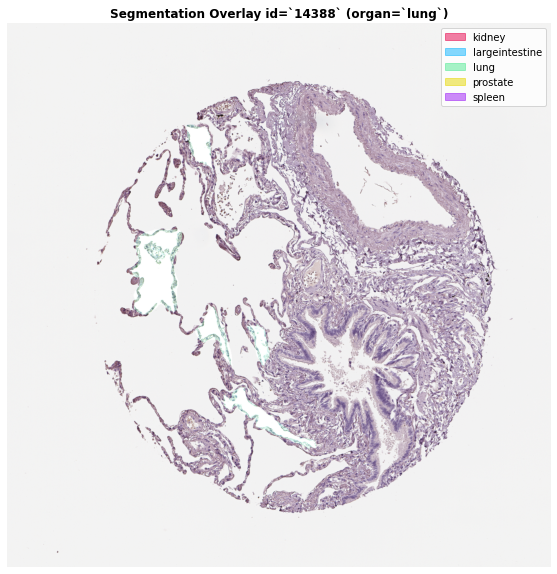



... SINGLE ID EXPLORATION FINISHED ...


Predicted


... IMAGE WITH RGB SEGMENTATION MASK OVERLAY (lung) ...



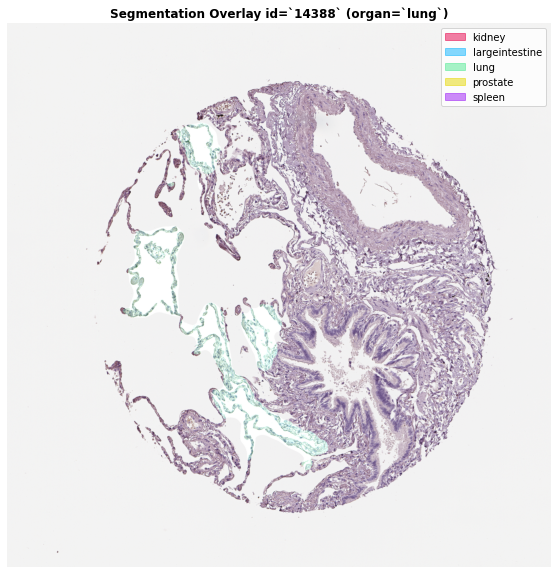



... SINGLE ID EXPLORATION FINISHED ...




In [42]:
print("Original")
examine_id(val_original, ex_id = None, plot_overlay=True, plot_original=False, plot_segmentation=False)
print("Predicted")
examine_id(val_pred, ex_id = None, plot_overlay=True, plot_original=False, plot_segmentation=False)